# Neural Network Python Tutorial: From ARIMA to LSTM-CNN Hybrid

In [15]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout

/tmp/ipython-input-702001622.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed


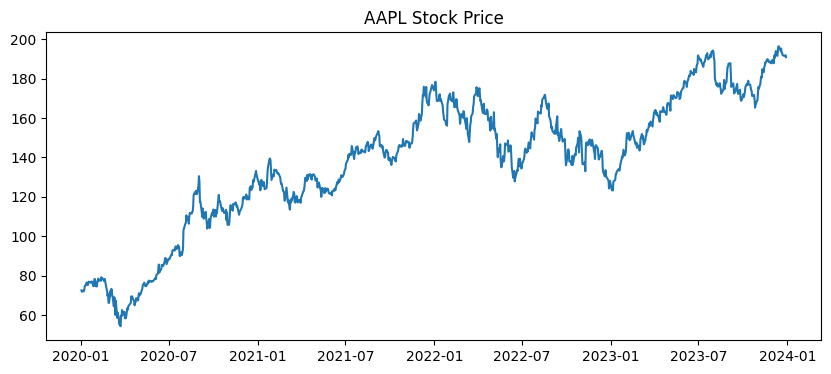

In [7]:
# Load Data

ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
close_prices = data['Close']

plt.figure(figsize=(10, 4))
plt.plot(close_prices)
plt.title(f'{ticker} Stock Price')
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

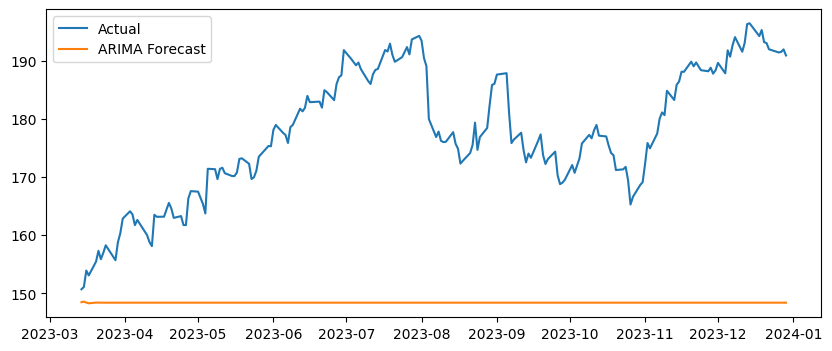

In [8]:
# ARIMA Model

train_size = int(len(close_prices) * 0.8)
train_arima, test_arima = close_prices[:train_size], close_prices[train_size:]

arima_model = ARIMA(train_arima, order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_preds = arima_fit.forecast(len(test_arima))

plt.figure(figsize=(10, 4))
plt.plot(test_arima.index, test_arima, label='Actual')
plt.plot(test_arima.index, arima_preds, label='ARIMA Forecast')
plt.legend()
plt.show()

In [9]:
# Data Preparation

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_prices.values.reshape(-1, 1))

def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(scaled_data, seq_len)
X = np.expand_dims(X, axis=2)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [10]:
# Hybrid LSTM-CNN Model

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_len, 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,307 (91.04 KB)

 Trainable params: 23,307 (91.04 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2239 - val_loss: 0.0038
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0122 - val_loss: 0.0031
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - val_loss: 0.0026
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - val_loss: 0.0025
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0060 - val_loss: 0.0029
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - val_loss: 0.0024
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 10/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0047 - val_loss: 0.0021
Epoch 11/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 12/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

In [12]:
# Predictions

preds = model.predict(X_test)
preds_rescaled = scaler.inverse_transform(preds)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


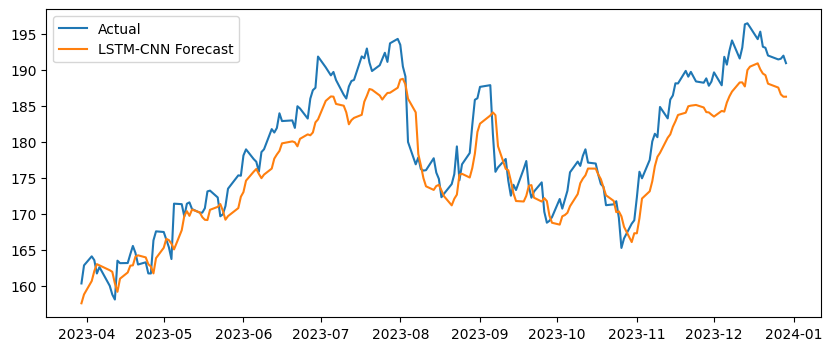

In [14]:
# Results

plt.figure(figsize=(10, 4))
plt.plot(data.index[seq_len+split:], y_test_rescaled, label='Actual')
plt.plot(data.index[seq_len+split:], preds_rescaled, label='LSTM-CNN Forecast')
plt.legend()
plt.show()